# Part 2

In [73]:
# Downloading/Installing Gensim
# pip install --upgrade gensim

In [74]:
# Import necessary libraries
import gensim.downloader
word2vec_google = gensim.downloader.load('word2vec-google-news-300')

In [75]:
# Import functions required from utils python file
from part_2_utils import save_pickle, load_pickle, split_text_into_words, createMatrix, padding, CustomDataset, EarlyStopper, plot_accuracy

In [103]:
# Import necessary libraries
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import time
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

np.random.seed(42)

[nltk_data] Downloading package punkt to C:\Users\Jun
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1) Datasets

### Reading dataset

In [108]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train = train.drop(['label-fine'], axis=1)
test = test.drop(['label-fine'], axis=1)
display(train)
display(test)

,label-coarse,text
0,0,How did serfdom develop in and then leave Russ...
1,1,What films featured the character Popeye Doyle ?
2,0,How can I find a list of celebrities ' real na...
3,1,What fowl grabs the spotlight after the Chines...
4,2,What is the full form of .com ?
...,...,...
5447,1,What 's the shape of a camel 's spine ?
5448,1,What type of currency is used in China ?
5449,4,What is the temperature today ?
5450,4,What is the temperature for cooking ?


,label-coarse,text
0,4,How far is it from Denver to Aspen ?
1,5,"What county is Modesto , California in ?"
2,3,Who was Galileo ?
3,0,What is an atom ?
4,4,When did Hawaii become a state ?
...,...,...
495,3,Who was the 22nd President of the US ?
496,1,What is the money they use in Zambia ?
497,4,How many feet in a mile ?
498,1,What is the birthstone of October ?


In [78]:
# Print unique labels in train and test dataset
train_labels = train['label-coarse'].sort_values().unique()
test_labels = test['label-coarse'].sort_values().unique()
print(f"Train labels: {train_labels}")
print(f"Test labels: {test_labels}")


Train labels: [0 1 2 3 4 5]
Test labels: [0 1 2 3 4 5]


### Re-classifying classes of original dataset

In [79]:
# Combine labels 2 and 5 to form single class 'OTHERS', denoted by label 2, for train and test dataset
train_mask = ((train['label-coarse']==2) | (train['label-coarse']==5))
test_mask = ((test['label-coarse']==2) | (test['label-coarse']==5))
train.loc[train_mask, 'label-coarse'] = 2
test.loc[test_mask, 'label-coarse'] = 2

display(train)
display(test)

,label-coarse,text
0,0,How did serfdom develop in and then leave Russ...
1,1,What films featured the character Popeye Doyle ?
2,0,How can I find a list of celebrities ' real na...
3,1,What fowl grabs the spotlight after the Chines...
4,2,What is the full form of .com ?
...,...,...
5447,1,What 's the shape of a camel 's spine ?
5448,1,What type of currency is used in China ?
5449,4,What is the temperature today ?
5450,4,What is the temperature for cooking ?


,label-coarse,text
0,4,How far is it from Denver to Aspen ?
1,2,"What county is Modesto , California in ?"
2,3,Who was Galileo ?
3,0,What is an atom ?
4,4,When did Hawaii become a state ?
...,...,...
495,3,Who was the 22nd President of the US ?
496,1,What is the money they use in Zambia ?
497,4,How many feet in a mile ?
498,1,What is the birthstone of October ?


In [80]:
train_labels_cleaned = train['label-coarse'].sort_values().unique()
test_labels_cleaned = test['label-coarse'].sort_values().unique()
print(f"Train labels: {train_labels_cleaned}")
print(f"Test labels: {test_labels_cleaned}")

Train labels: [0 1 2 3 4]
Test labels: [0 1 2 3 4]


### Splitting into train and dev set

In [81]:
from sklearn.model_selection import train_test_split

print("Original train size:", train.shape)

train_set, dev_set = train_test_split(train, test_size = 500)

print("New train size:", train_set.shape)
print("New development set size:", dev_set.shape)
display(train_set)
display(dev_set)

Original train size: (5452, 2)
New train size: (4952, 2)
New development set size: (500, 2)


,label-coarse,text
4943,2,What is Mikhail Gorbachev 's middle initial ?
2346,0,How does the tail affect the flight of a kite ?
1835,2,What were the first three cities to have a pop...
4047,1,What is the movie Jonathan Livingstone Seagull ?
5097,1,What is a fear of home surroundings ?
...,...,...
3772,4,How much Coca Cola is drunk in one day in the ...
5191,2,What cathedral was Thomas Becket murdered in ?
5226,3,What character in The Beverly Hillbillies has ...
5390,2,What does the River Seine empty into ?


,label-coarse,text
3408,2,What city is served by Tempelhol Airport ?
371,1,What is Dudley Do-Right 's horse 's name ?
453,0,What 's nature 's purpose for tornadoes ?
290,0,What is the history of Valentine 's Day cards ?
4457,3,What President became Chief Justice after his ...
...,...,...
472,1,What 's the most commonly-spoken language in B...
691,2,What is the leading pecan and peanut growing s...
3066,3,Name the three races unleashed by the Celestia...
555,2,Where do people mountain climb in Nepal ?


## 2) Neural Network Implementation

### Input Pre-processing
Architecture: Split sentences into words --> Apply word2vec embeddings --> Map embeddings to indices (word indexing) --> Padding --> Convert to PyTorch tensor --> Create DataLoader to load data for model training

In [82]:
train_wordList = split_text_into_words(train_set, 'text')
dev_wordList = split_text_into_words(dev_set, 'text')
test_wordList = split_text_into_words(test, 'text')


In [83]:
train_wordList[0]

['What', 'is', 'Mikhail', 'Gorbachev', "'s", 'middle', 'initial', '?']

In [84]:
# Finding the longest sentence in the whole dataset (train, dev and test)
train_maxlen = train_set['text'].str.split().str.len().max()
dev_maxlen = dev_set['text'].str.split().str.len().max()
test_maxlen = test['text'].str.split().str.len().max()

print(train_maxlen, dev_maxlen, test_maxlen)

37 31 17


In [85]:
# Create label set and word set
labelSet = set()
wordSet = set()

# unique words and labels in data
for dataset in [train_set, test, dev_set]:
    for index, row in dataset.iterrows():
        sentence = row['text']
        label = row['label-coarse']
        labelSet.add(label)
        for word in sentence.split():
            wordSet.add(word.lower())


embed_size = len(word2vec_google.vectors[0])

# Get all words in the word2vec model
w2v_dictionary = list(word2vec_google.key_to_index.keys())

wordEmbeddings = []
# adding vector for padding token
wordEmbeddings.append(np.zeros(embed_size))
# adding vector for unknown vector intialised with uniform distribution
wordEmbeddings.append(np.random.uniform(-0.25, 0.25, embed_size))

# Initialise dictionary to map each word to a unique index
word2Idx = {}

# add padding+unknown
word2Idx["PADDING_TOKEN"] = len(word2Idx)
word2Idx["UNKNOWN_TOKEN"] = len(word2Idx)

# adding vector for words present in the CoNLL2003 dataset
for word in w2v_dictionary:
    try:
        if word.lower() in wordSet:
            embedding_vector = word2vec_google.get_vector(word)
            if embedding_vector is not None:
                wordEmbeddings.append(embedding_vector)
                word2Idx[word] = len(word2Idx)
    except Exception as e:
        pass

wordEmbeddings = np.array(wordEmbeddings)

# format: [[padded wordindices], [caseindices], [padded char indices], [label indices]]

In [86]:
# Converting list of word indices and labels into PyTorch tensors
trainSentences = torch.tensor(padding(createMatrix(train_wordList, word2Idx), train_maxlen))
devSentences = torch.tensor(padding(createMatrix(dev_wordList, word2Idx), train_maxlen))
testSentences = torch.tensor(padding(createMatrix(test_wordList, word2Idx), train_maxlen))

trainLabels = torch.tensor(train_set['label-coarse'].tolist())
devLabels = torch.tensor(dev_set['label-coarse'].tolist())
testLabels = torch.tensor(test['label-coarse'].tolist())

In [87]:
from torch.utils.data import Dataset, DataLoader

# Create DataLoader
train_dataloader = DataLoader(CustomDataset(trainSentences, trainLabels), batch_size=64, shuffle=True)
dev_dataloader = DataLoader(CustomDataset(devSentences, devLabels), batch_size=64, shuffle=True)


In [88]:
trainSentences.dtype

torch.int64

In [89]:
wordEmbeddings.shape

(22955, 300)

### 2.1) BiLSTM Implementation

In [90]:
# Define your Bi-LSTM model
class BiLSTMModel(nn.Module):
    def __init__(self, hidden_size, num_classes,wordEmbeddings,aggregation_method, dropout_rate):
        super(BiLSTMModel, self).__init__()  # Call the superclass's __init__ method

        self.wordEmbeddings = wordEmbeddings
        self.hidden_size = hidden_size
        self.aggregation_method = aggregation_method
        self.dropout_rate = dropout_rate

        self.embedding = nn.Embedding.from_pretrained(embeddings=self.wordEmbeddings,freeze=True,padding_idx=0)
        self.dropout = nn.Dropout(p=self.dropout_rate)

        self.bilstm = nn.LSTM(input_size=self.wordEmbeddings.shape[1], hidden_size=self.hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Multiply by 2 for bidirectional
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = x.to(torch.long)  # Convert the data type of the inputs
        embed_out = self.embedding(x)
        embed_out = embed_out.to(torch.float32)
        lstm_out, _ = self.bilstm(embed_out)

        # Create a mask that is the same size as the input tensor
        mask = (x != 0).float()
        # Apply the mask to the output of the LSTM layer
        lstm_out = lstm_out * mask.unsqueeze(-1)

        if self.aggregation_method == 'avg':
           agg_output = torch.sum(lstm_out, dim=1) / torch.sum(mask, dim=1).unsqueeze(-1)
        elif self.aggregation_method == 'max':
            agg_output = torch.max(lstm_out, dim=1)[0]

        fc_out = self.fc(agg_output)
        softmax_out = self.softmax(fc_out)

        return softmax_out

### 2.2) Model training and initialisation

In [91]:
# Creating function for training of machine learning model
def train(model, train_dataloader, dev_dataloader,criterion, optimizer, epochs, early_stopping):

   train_accs = []
   dev_accs = []
   best_model = None
   best_dev_acc = 0

   for epoch in range(epochs):

      model.train()
      correct = 0
      total = 0
      for inputs,labels in train_dataloader:

         # Zero the parameter gradients
         optimizer.zero_grad()

         # Forward pass
         outputs = model(inputs)
         loss = criterion(outputs, labels)

         preds = torch.argmax(outputs,dim=1)

         # Backward pass and optimize
         loss.backward()
         optimizer.step()

         # Calculate accuracy
         correct += torch.sum(preds == labels)
         total += labels.size(0)
      train_accuracy = correct.double()/total
      train_accs.append(train_accuracy)

      model.eval()
      correct = 0
      total = 0
      with torch.no_grad():
         for inputs,labels in dev_dataloader:

            # Forward pass
            outputs = model(inputs)

            preds = torch.argmax(outputs,dim=1)

            # Calculate accuracy
            correct += torch.sum(preds == labels)
            total += labels.size(0)

      dev_accuracy = correct.double()/total
      dev_accs.append(dev_accuracy)

      print(f"Epoch: {epoch+1}, Train Acc: {train_accuracy}, Dev Acc: {dev_accuracy}")

      if dev_accuracy > best_dev_acc:
          best_model = model
          best_dev_acc = dev_accuracy

      if early_stopping.early_stop(dev_accuracy):
          print(f"Early Stopping at Epoch:{epoch+1}")
          break

   print("Best model val_acc:", best_dev_acc)
   return model,train_accs,dev_accs,best_model

#### Average pooling aggregation method

In [92]:
avg_pool_blstm = BiLSTMModel(hidden_size=256, num_classes=5, wordEmbeddings=torch.tensor(wordEmbeddings), aggregation_method='avg', dropout_rate=0.5)

early_stopper = EarlyStopper()
loss_fn = nn.CrossEntropyLoss()
lr = 0.001
num_epochs = 100
optimizer = optim.Adam(avg_pool_blstm.parameters(), lr=lr)

In [93]:
start = time.time()
avg_pool_blstm, train_acc,val_acc, best_avg_pool_lstm = train(avg_pool_blstm, train_dataloader, dev_dataloader, criterion=loss_fn, early_stopping=early_stopper, epochs=num_epochs, optimizer=optimizer)
end = time.time()

Epoch: 1, Train Acc: 0.4052907915993538, Dev Acc: 0.582
Epoch: 2, Train Acc: 0.6882067851373183, Dev Acc: 0.744
Epoch: 3, Train Acc: 0.7358642972536349, Dev Acc: 0.72
Epoch: 4, Train Acc: 0.7817043618739903, Dev Acc: 0.766
Epoch: 5, Train Acc: 0.7487883683360258, Dev Acc: 0.642
Epoch: 6, Train Acc: 0.7538368336025848, Dev Acc: 0.75
Epoch: 7, Train Acc: 0.8293618739903069, Dev Acc: 0.816
Epoch: 8, Train Acc: 0.843497576736672, Dev Acc: 0.814
Epoch: 9, Train Acc: 0.8667205169628432, Dev Acc: 0.832
Epoch: 10, Train Acc: 0.8729806138933764, Dev Acc: 0.82
Epoch: 11, Train Acc: 0.8939822294022617, Dev Acc: 0.842
Epoch: 12, Train Acc: 0.9137722132471728, Dev Acc: 0.854
Epoch: 13, Train Acc: 0.9026655896607432, Dev Acc: 0.848
Epoch: 14, Train Acc: 0.901453957996769, Dev Acc: 0.83
Epoch: 15, Train Acc: 0.9170032310177706, Dev Acc: 0.858
Epoch: 16, Train Acc: 0.9321486268174475, Dev Acc: 0.864
Epoch: 17, Train Acc: 0.9367932148626817, Dev Acc: 0.84
Epoch: 18, Train Acc: 0.9406300484652665, Dev A

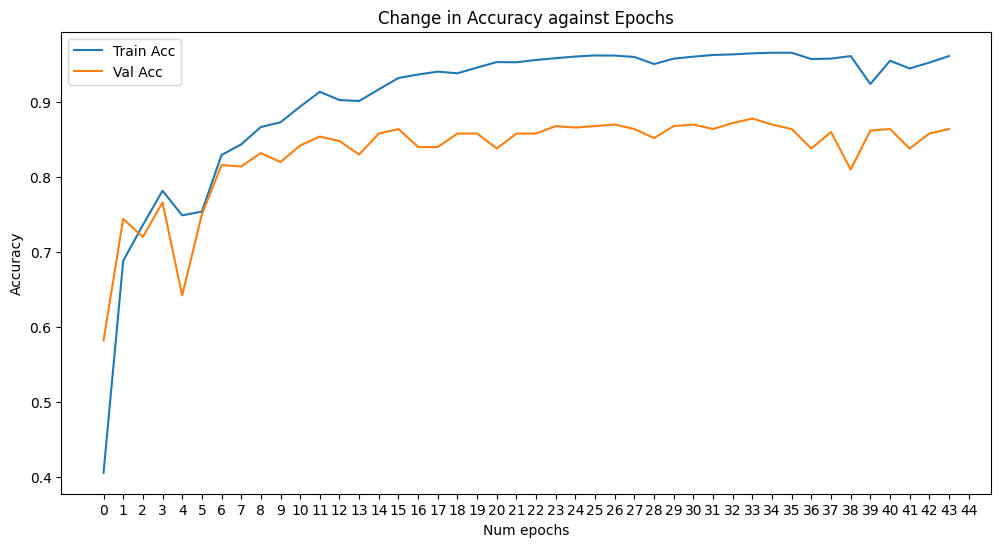

In [94]:
plot_accuracy(train_acc, val_acc)

#### Max pooling aggregation method

In [95]:
max_pool_blstm = BiLSTMModel(hidden_size=256, num_classes=5, wordEmbeddings=torch.tensor(wordEmbeddings), aggregation_method='max', dropout_rate=0.5)

early_stopper = EarlyStopper()
loss_fn = nn.CrossEntropyLoss()
lr = 0.001
num_epochs = 100
optimizer = optim.Adam(max_pool_blstm.parameters(), lr=lr)

In [96]:
start = time.time()
max_pool_blstm, max_train_acc, max_val_acc, best_max_pool_lstm = train(max_pool_blstm, train_dataloader, dev_dataloader, criterion=loss_fn, early_stopping=early_stopper, epochs=num_epochs, optimizer=optimizer)
end = time.time()
print(end-start)

Epoch: 1, Train Acc: 0.3861066235864297, Dev Acc: 0.572
Epoch: 2, Train Acc: 0.702140549273021, Dev Acc: 0.758
Epoch: 3, Train Acc: 0.8043214862681745, Dev Acc: 0.75
Epoch: 4, Train Acc: 0.8289579967689822, Dev Acc: 0.816
Epoch: 5, Train Acc: 0.8737883683360258, Dev Acc: 0.826
Epoch: 6, Train Acc: 0.9010500807754442, Dev Acc: 0.852
Epoch: 7, Train Acc: 0.9178109854604201, Dev Acc: 0.83
Epoch: 8, Train Acc: 0.9337641357027464, Dev Acc: 0.866
Epoch: 9, Train Acc: 0.9376009693053312, Dev Acc: 0.864
Epoch: 10, Train Acc: 0.9501211631663974, Dev Acc: 0.874
Epoch: 11, Train Acc: 0.9567851373182552, Dev Acc: 0.868
Epoch: 12, Train Acc: 0.960016155088853, Dev Acc: 0.852
Epoch: 13, Train Acc: 0.9622374798061389, Dev Acc: 0.876
Epoch: 14, Train Acc: 0.9646607431340872, Dev Acc: 0.878
Epoch: 15, Train Acc: 0.9658723747980614, Dev Acc: 0.878
Epoch: 16, Train Acc: 0.9680936995153473, Dev Acc: 0.882
Epoch: 17, Train Acc: 0.9682956381260097, Dev Acc: 0.88
Epoch: 18, Train Acc: 0.9697092084006462, Dev

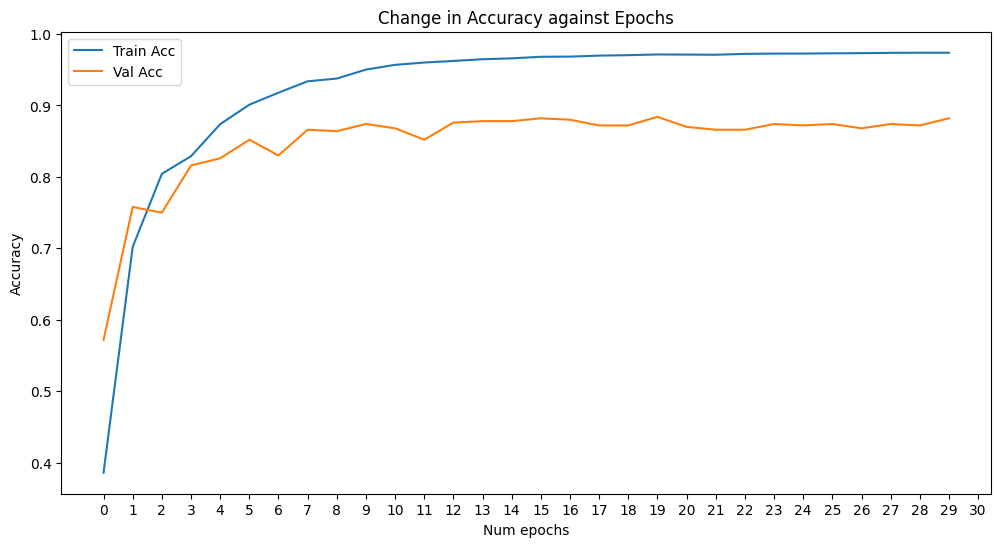

In [97]:
plot_accuracy(max_train_acc, max_val_acc)

### 2.3) Model evaluation
Perform ML model evaluation by running on test dataset and predicting the labels

In [98]:
test_dataloader = DataLoader(CustomDataset(testSentences, testLabels), batch_size=64, shuffle=True)

In [99]:
def test(model, test_dataloader):
   model.eval()
   correct = 0
   total = 0
   with torch.no_grad():
       for inputs, labels in test_dataloader:
           outputs = model(inputs)
           preds = torch.argmax(outputs, dim=1)
           correct += torch.sum(preds == labels)
           total += labels.size(0)
   test_accuracy = correct.double() / total
   return test_accuracy

In [100]:
test_accuracy = test(best_max_pool_lstm, test_dataloader)
print(f"Test Accuracy for best model (Max Pool BiLSTM): {test_accuracy}")

Test Accuracy for best model (Max Pool BiLSTM): 0.912


### 2.4) Save best model weights

In [101]:
model_attrs = [
    best_max_pool_lstm.hidden_size,
    best_max_pool_lstm.aggregation_method,
    best_max_pool_lstm.dropout_rate,
    lr,
    optimizer.__class__.__name__
]
model_vers = "_".join([str(i) for i in model_attrs])
model_vers

'256_max_0.5_0.001_Adam'

In [105]:
# DIR = "C:\\Users\\Jun Wei\\Desktop\\NTU\\Y4S1\\CE4045 (Natural Language Processing)\\Assignment"

model_name = f"{model_vers}.pkl"
save_pickle(best_max_pool_lstm, os.path.join(DIR, model_name))
print("Model weights saved.")

Model weights saved.


In [106]:
loaded_model = load_pickle(os.path.join(DIR, model_name))

In [107]:
loaded_model

BiLSTMModel(
  (embedding): Embedding(22955, 300, padding_idx=0)
  (dropout): Dropout(p=0.5, inplace=False)
  (bilstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)